
## 1. Project formulation
The goal of the project is to conduct a negative Bayesian and Poisson analysis of points scored by both teams in NBA game. This involves understanding the factors that influence game outcomes, such as team-specific offensive and defensive strengths, home-court advantage.

 By understanding and quantifying the factors that influence game outcomes, various stakeholders can benefit. Outcome can be highly useful for people involved in betting. It can also be useful for broadcasters and sports media by incorporating predictive analytics into pre-game and post-game analyses.

The data for 2022, 2023 seasons was scraped from official NBA website (www.nba.com/stats). After that, the duplicates were removed and data was sorted by date. Unique team IDs were created for better readibility in stan. Below is the representation of all columns in the prepared dataset:
1. start_time
2. away_team
3. away_team_score
4. home_team
5. home_team_score
6. home_team_id
7. away_team_id

Confoudings
1. Pipes

home_team_score -> home_score_pred

home_team_score -> away_def -> away_score_pred

away_team_score -> away_score_pred

away_team_score -> home_def -> home_score_pred

2. Forks

home_team_score influences home_score_pred and away_score_pred

away_team_score influences away_score_pred and home_score_pred

3. Colliders

None

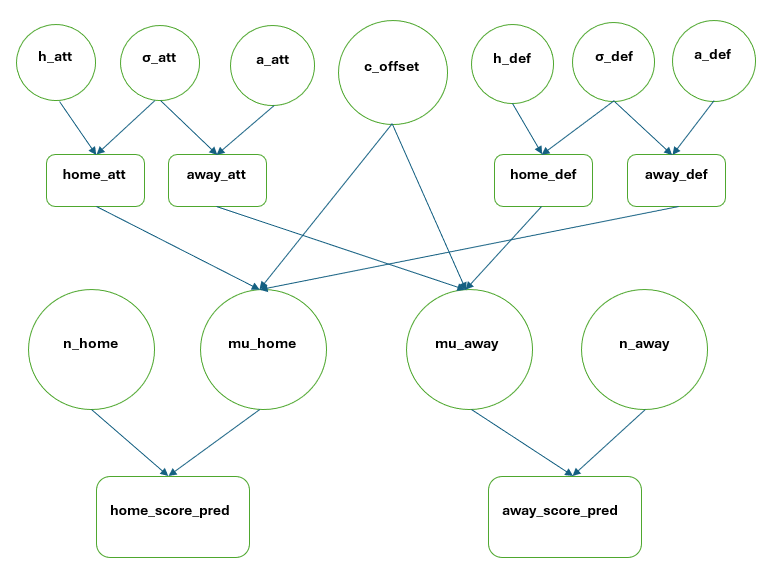

In [32]:
from PIL import Image
from IPython.display import display

DAG_nbin = Image.open('DAG_nbin.png')
display(DAG_nbin)

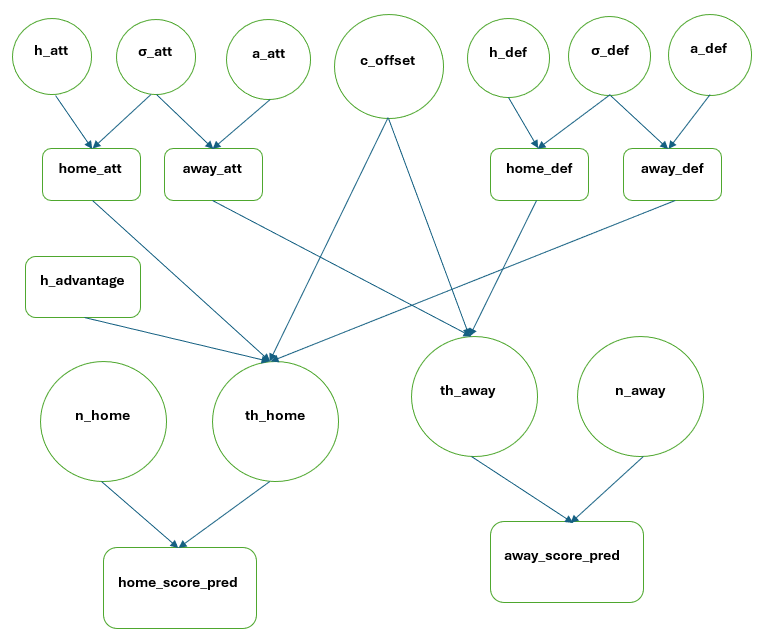

In [34]:
DAG_poisson = Image.open('DAG_poisson.png')
display(DAG_poisson)

In [1]:
import os

from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom, norm, poisson, gamma
import arviz as az

os.chdir('/app')

from src.web_scraping.scraper import scrap_games

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input parameters for scraping

In [2]:
years = list(range(2022, 2024))
train_year = years[0]
pred_year = years[1]

Scraping

In [3]:
scrap_games(years)

Read data

In [4]:
path = 'src/data/'
path_games = os.path.join(path, 'games/')
seasons_games = {}

# prepare dataframes - drop duplicated rows and sort by date
for year in years:
    seasons_games[year] = pd.read_csv(os.path.join(path_games, f'{year-1}_{year}_season.csv')).drop_duplicates().sort_values(by='start_time').reset_index(drop=True)
print(seasons_games)

{2022:                      start_time              away_team  away_team_score  \
0     2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1     2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2     2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3     2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4     2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   
...                         ...                    ...              ...   
1318  2022-06-06 00:00:00+00:00         BOSTON CELTICS               88   
1319  2022-06-09 01:00:00+00:00  GOLDEN STATE WARRIORS              100   
1320  2022-06-11 01:00:00+00:00  GOLDEN STATE WARRIORS              107   
1321  2022-06-14 01:00:00+00:00         BOSTON CELTICS               94   
1322  2022-06-17 01:00:00+00:00  GOLDEN STATE WARRIORS              103   

                  home_team  home_team_score  
0           MILWAUKEE BUCKS              127 

Edit dataframe

In [5]:
# get unique team names
teams = list(seasons_games[train_year]['home_team'].unique())
print(teams)
# map team to id
team_to_id = {team: i + 1 for i, team in enumerate(teams)}

for year in years:
    # Add IDs of teams to be differentiate for stan
    seasons_games[year]['home_team_id'] = seasons_games[year]['home_team'].map(team_to_id)
    seasons_games[year]['away_team_id'] = seasons_games[year]['away_team'].map(team_to_id)

    # Add difference in points between home team and away team
    for year in years:
        seasons_games[year]['difference'] = seasons_games[year]['home_team_score'] - seasons_games[year]['away_team_score']


['MILWAUKEE BUCKS', 'LOS ANGELES LAKERS', 'CHARLOTTE HORNETS', 'DETROIT PISTONS', 'NEW YORK KNICKS', 'TORONTO RAPTORS', 'MEMPHIS GRIZZLIES', 'MINNESOTA TIMBERWOLVES', 'NEW ORLEANS PELICANS', 'SAN ANTONIO SPURS', 'UTAH JAZZ', 'PORTLAND TRAIL BLAZERS', 'PHOENIX SUNS', 'ATLANTA HAWKS', 'MIAMI HEAT', 'GOLDEN STATE WARRIORS', 'ORLANDO MAGIC', 'WASHINGTON WIZARDS', 'CLEVELAND CAVALIERS', 'PHILADELPHIA 76ERS', 'BOSTON CELTICS', 'HOUSTON ROCKETS', 'CHICAGO BULLS', 'DENVER NUGGETS', 'SACRAMENTO KINGS', 'INDIANA PACERS', 'LOS ANGELES CLIPPERS', 'BROOKLYN NETS', 'OKLAHOMA CITY THUNDER', 'DALLAS MAVERICKS']


Show data (first 5 rows)

In [6]:
for year in years:
    print(seasons_games[year].head())

                  start_time              away_team  away_team_score  \
0  2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1  2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2  2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3  2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4  2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   

            home_team  home_team_score  home_team_id  away_team_id  difference  
0     MILWAUKEE BUCKS              127             1            28          23  
1  LOS ANGELES LAKERS              114             2            16          -7  
2   CHARLOTTE HORNETS              123             3            26           1  
3     DETROIT PISTONS               88             4            23          -6  
4     NEW YORK KNICKS              138             5            21           4  
                  start_time           away_team  away_team_score  \
0  2022-10-1

Plot data

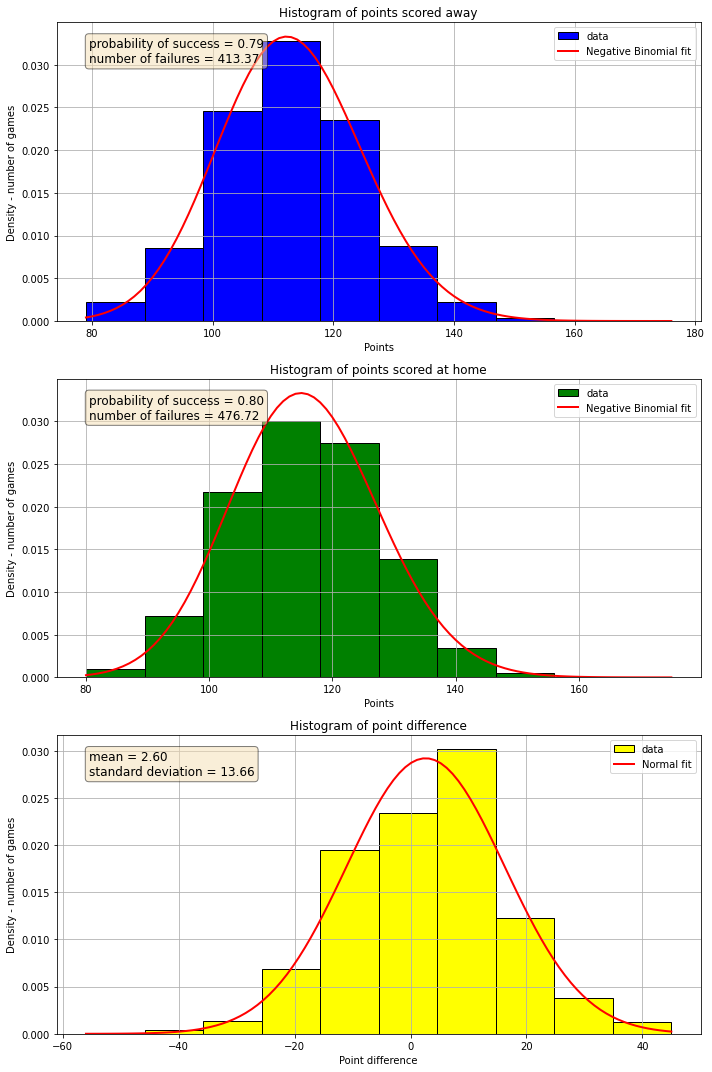

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=10, color='blue', edgecolor='black', label='data')
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=10, color='green', edgecolor='black', label='data')
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

# Histogram of point difference
axes[2].hist(seasons_games[year]['difference'], density=True, bins=10, color='yellow', edgecolor='black', label='data')
axes[2].set_title('Histogram of point difference')
axes[2].set_xlabel('Point difference')
axes[2].set_ylabel('Density - number of games')

# Plot the negative binomial PDF on each chart
for ax, col in zip(axes, ('away_team_score', 'home_team_score', 'difference')):
    mean, var = np.mean(seasons_games[year][col]), np.var(seasons_games[year][col])
    if col == 'difference':
        std = np.sqrt(var)
        x = np.linspace(min(seasons_games[year][col]), max(seasons_games[year][col]), 100)
        normal_pdf = norm.pdf(x, mean, std)
    
        # Plot the normal PDF
        ax.plot(x, normal_pdf, 'r-', lw=2, label='Normal fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    else:
        p = mean / var
        r = mean ** 2 / (var - mean)  # Number of failures
        x = np.arange(min(seasons_games[year][col]), max(seasons_games[year][col]) + 1)
        nbinom_pmf = nbinom.pmf(x, r, p)
            
        # Plot the negative binomial PDF
        ax.plot(x, nbinom_pmf, 'r-', lw=2, label='Negative Binomial fit')
        
        textstr = f'probability of success = {p:.2f}\nnumber of failures = {r:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    ax.legend()
    ax.grid()

plt.tight_layout()

Prepare input data

In [8]:
inp_data = {
    'teams_number': len(teams),
    'games_number': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_score': seasons_games[train_year].home_team_score.to_numpy(),
    'away_score': seasons_games[train_year].away_team_score.to_numpy(),
}

# 2. Evaluation of Poisson and Negative Binomial Models

The primary distinction lies in the flexibility of the Negative Binomial model, which introduces an additional parameter compared to the Poisson model. This additional parameter allows the Negative Binomial model to better accommodate the variability in the data, leading to improved predictive accuracy.

Negative Binomial provides a better fit for the data due to its ability to handle overdispersion, which is a common characteristic in sports data where the variance exceeds the mean. Negative Binomial model consistently outperforms the Poisson model in terms of predictive accuracy.

The Poisson model is described by a single parameter (λ), representing the mean number of events, while the Negative Binomial model introduces an additional parameter (r), which accounts for the overdispersion. The data required for these models include the observed counts of events, such as scores in basketball games, along with other covariates that may influence the outcome.

## MODEL 1 Negative Binomial

### Prior

Prior parameters were chosen experimentally

In [9]:
model_nbinomial_prior = CmdStanModel(stan_file='src/model/model_nbinomial_prior.stan')
samples = 1000
sim_nbin_prior=model_nbinomial_prior.sample(iter_sampling=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [10]:
mod_nbin_prior = sim_nbin_prior.draws_pd()
print(mod_nbin_prior)

      lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0      0.0            0.0            101.0            134.0     0.673539   
1      0.0            0.0            163.0            162.0    -1.104520   
2      0.0            0.0            131.0             76.0     0.483473   
3      0.0            0.0             64.0             88.0     0.447790   
4      0.0            0.0            102.0            161.0     0.156960   
...    ...            ...              ...              ...          ...   
3995   0.0            0.0            136.0            145.0     1.616090   
3996   0.0            0.0            146.0             96.0    -0.189387   
3997   0.0            0.0            135.0            110.0     1.403610   
3998   0.0            0.0            100.0             76.0     0.357580   
3999   0.0            0.0             99.0             94.0    -0.000858   

      mu_away_att  mu_home_def  mu_away_def  sigma2_att  sigma2_def  phi_home  \
0     

Text(0, 0.5, 'Density - number of games')

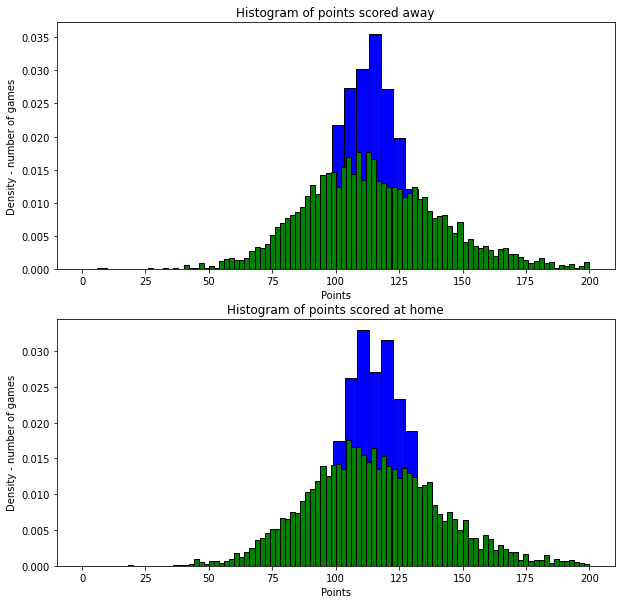

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_nbin_prior.stan_variable('away_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_nbin_prior.stan_variable('home_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

### Posterior

In [14]:
model_nbinomial_post = CmdStanModel(stan_file='src/model/model_nbinomial_posterior.stan')
samples = 10000
sim_nbinomial_post=model_nbinomial_post.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1
                     )

INFO:cmdstanpy:compiling stan file /app/src/model/model_nbinomial_posterior.stan to exe file /app/src/model/model_nbinomial_posterior
INFO:cmdstanpy:compiled model executable: /app/src/model/model_nbinomial_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:37 Sampling completed                         


INFO:cmdstanpy:CmdStan done processing.


In [15]:
mod_nbin_post = sim_nbinomial_post.draws_pd()
print(mod_nbin_post)

         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -62965.7            0.0     14.3855          0.0           1.0   
1    -62965.7            0.0     14.3855          0.0           1.0   
2    -62965.7            0.0     14.3855          0.0           1.0   
3    -62965.7            0.0     14.3855          0.0           1.0   
4    -62965.7            0.0     14.3855          0.0           1.0   
...       ...            ...         ...          ...           ...   
9995 -62965.7            0.0     14.3855          0.0           1.0   
9996 -62965.7            0.0     14.3855          0.0           1.0   
9997 -62965.7            0.0     14.3855          0.0           1.0   
9998 -62965.7            0.0     14.3855          0.0           1.0   
9999 -62965.7            0.0     14.3855          0.0           1.0   

      divergent__  energy__  mu_home_att  mu_away_att  mu_home_def  ...  \
0             1.0   63036.4     0.768614     0.204185     0.242971  ... 

Text(0, 0.5, 'Density - number of games')

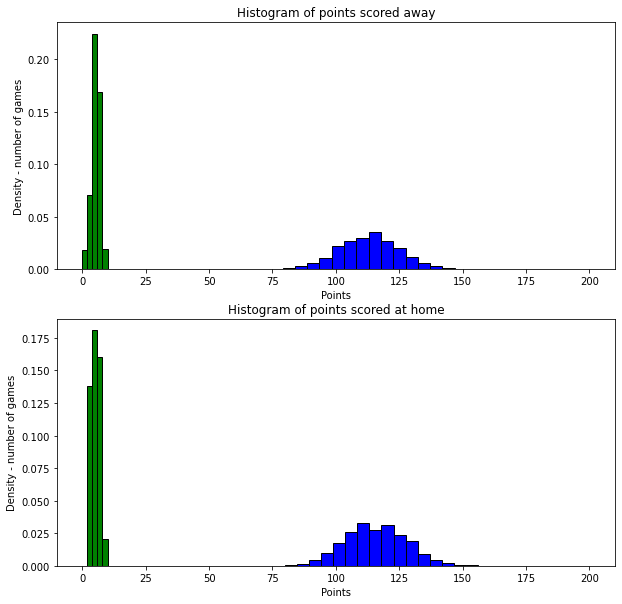

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_nbinomial_post.stan_variable('away_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_nbinomial_post.stan_variable('home_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

## Model 2 - Poisson

### Prior

In [17]:
model_poiss_prior = CmdStanModel(stan_file='src/model/model_poisson_prior.stan')
samples = 1000
sim_poiss_prior=model_poiss_prior.sample(data=inp_data,
                     iter_sampling=samples,
                     #iter_warmup=1,
                     chains=1
                     )

INFO:cmdstanpy:compiling stan file /app/src/model/model_poisson_prior.stan to exe file /app/src/model/model_poisson_prior
INFO:cmdstanpy:compiled model executable: /app/src/model/model_poisson_prior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [18]:
mod_poiss_prio = sim_poiss_prior.draws_pd()
print(mod_poiss_prio)

     lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0     0.0            0.0              8.0             13.0    -0.000037   
1     0.0            0.0             70.0             70.0    -0.000016   
2     0.0            0.0             50.0             48.0    -0.000038   
3     0.0            0.0              0.0              0.0    -0.000007   
4     0.0            0.0             50.0             57.0     0.000122   
..    ...            ...              ...              ...          ...   
995   0.0            0.0             61.0             51.0    -0.000066   
996   0.0            0.0             63.0             44.0     0.000080   
997   0.0            0.0             55.0             56.0    -0.000082   
998   0.0            0.0             50.0             67.0    -0.000077   
999   0.0            0.0             61.0             61.0    -0.000156   

     mu_away_att  mu_home_def  mu_away_def    sigma2_att    sigma2_def  ...  \
0       0.000026    

/usr/local/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0, 0.5, 'Density - number of games')

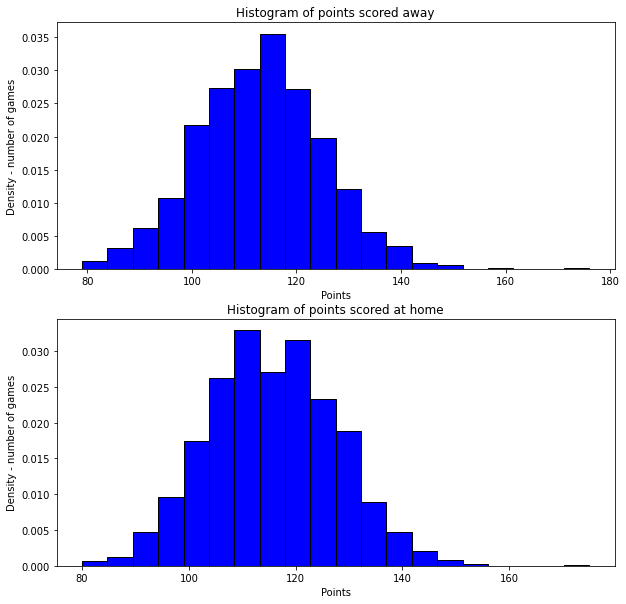

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_poiss_prior.stan_variable('away_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_poiss_prior.stan_variable('home_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

### Posterior

In [20]:
model_poiss_post = CmdStanModel(stan_file='src/model/model_poisson_posterior.stan')
samples = 1000
sim_poiss_post=model_poiss_post.sample(data=inp_data,
                     iter_sampling=samples,
                     #iter_warmup=1,
                     chains=1
                     )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:43 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [21]:
mod_poiss_post = sim_poiss_post.draws_pd()
print(mod_poiss_post)

          lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    1081410.0       0.988088    0.026701          7.0         127.0   
1    1081420.0       0.997769    0.026701          7.0         127.0   
2    1081420.0       0.728117    0.026701          7.0         127.0   
3    1081410.0       0.920981    0.026701          7.0         127.0   
4    1081400.0       0.977844    0.026701          7.0         127.0   
..         ...            ...         ...          ...           ...   
995  1081410.0       0.705729    0.026701          7.0         127.0   
996  1081430.0       0.740747    0.026701          7.0         127.0   
997  1081420.0       0.839895    0.026701          7.0         127.0   
998  1081420.0       0.785026    0.026701          7.0         127.0   
999  1081400.0       0.866736    0.026701          7.0         127.0   

     divergent__   energy__   mu_home_att  mu_away_att   mu_home_def  ...  \
0            0.0 -1081340.0 -8.102100e-05     0.000079 -3.

Text(0, 0.5, 'Density - number of games')

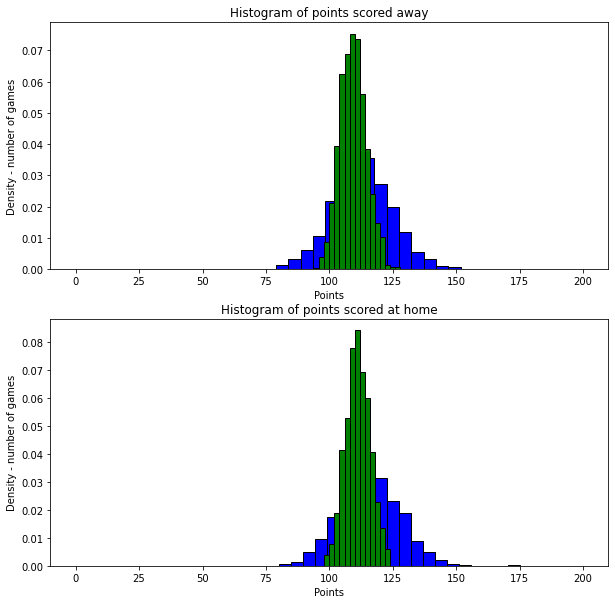

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_poiss_post.stan_variable('away_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_poiss_post.stan_variable('home_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


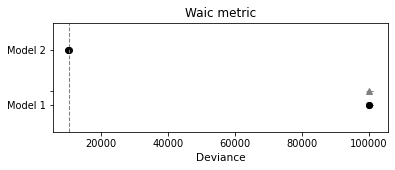

In [23]:
idata_nbin = az.from_cmdstanpy(posterior=sim_nbinomial_post, log_likelihood={"home": "log_lik_home"})
idata_poisson = az.from_cmdstanpy(posterior=sim_poiss_post, log_likelihood={"home": "log_lik_home"})

# Comparing models
comp_dict = {'Model 1': idata_nbin, "Model 2": idata_poisson}

comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()

In [24]:
comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Model 2,0,10303.514954,6.308309e+01,0.000000,1.0,62.78259,0.000000,True,deviance
Model 1,1,100107.011400,1.241983e-25,89803.496446,0.0,991.61028,995.448063,False,deviance


/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


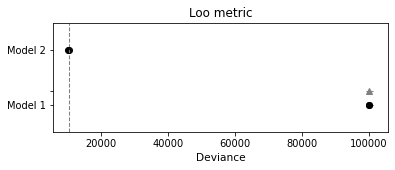

In [25]:
comp_loo = az.compare(comp_dict, ic='loo', scale='deviance')
az.plot_compare(comp_loo)
plt.title("Loo metric")
plt.show()

In [26]:
comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Model 2,0,10303.638666,63.144947,0.000000,1.0,62.781525,0.000000,False,deviance
Model 1,1,100107.011400,0.000000,89803.372734,0.0,991.610280,995.448912,True,deviance


/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


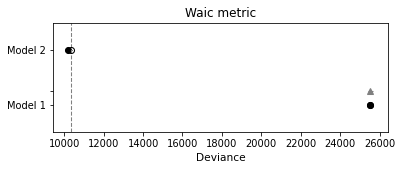

In [27]:
idata_nbin = az.from_cmdstanpy(posterior=sim_nbinomial_post, log_likelihood={"away": "log_lik_away"})
idata_poisson = az.from_cmdstanpy(posterior=sim_poiss_post, log_likelihood={"away": "log_lik_away"})

# Comparing models
comp_dict = {'Model 1': idata_nbin, "Model 2": idata_poisson}

comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()

In [28]:
comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Model 2,0,10346.956376,6.609384e+01,0.000000,1.0,63.643745,0.000000,True,deviance
Model 1,1,25529.842920,5.337433e-27,15182.886544,0.0,102.835006,120.996935,False,deviance


/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


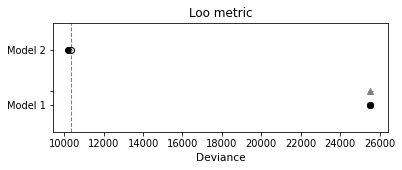

In [29]:
comp_loo = az.compare(comp_dict, ic='loo', scale='deviance')
az.plot_compare(comp_loo)
plt.title("Loo metric")
plt.show()

In [30]:
comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Model 2,0,10347.171248,66.201278,0.000000,1.000000e+00,63.661113,0.00000,False,deviance
Model 1,1,25529.842920,0.000000,15182.671672,5.995204e-14,102.835006,121.00358,True,deviance


# 3. Model comparision

### Results for loo criterion

When comparing models using the Loo criterion, an error occurred 

Clear Winner: Poisson model is the clear winner with a significantly lower WAIC score, indicating better predictive accuracy compared to Negative Binomial model.

Overlap: The substantial difference in LOO scores clearly favors Poisson model, with no significant overlap.

Warnings: The warning suggests that Negative Binomial model may not be robust. Non-robust models are more sensitive to individual observations, and making LOO estimates less reliable.

### Results for waic criterion
Clear Winner: Poisson model is the clear winner with a significantly lower WAIC score, indicating better predictive accuracy compared to Negative Binomail model.

Overlap: Given the large difference in WAIC scores, there is no overlap, clearly favoring Poisson model.

Warnings: The warning for Poisson model suggests some issues with WAIC calculation, indicating that the posterior variance of the log predictive densities exceeds 0.4. This means that while Poisson model has a better WAIC score, caution is needed in interpreting this result, and further validation might be necessary.